In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def get_data(data_dir):
    images = []
    image_labels = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # 0 for PNEUMONIA, 1 for NORMAL
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue  # Skip if image can't be read
                
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                image_labels.append(class_num)
            
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    # Convert to NumPy arrays
    images = np.array(images, dtype=np.float32)  # Shape: (N, 128, 128)
    image_labels = np.array(image_labels, dtype=np.int32)  # Shape: (N,)

    return images, image_labels


In [4]:
train_images, train_labels = get_data("../DL/chest_xray/chest_xray/train")
test_images, test_labels = get_data("../DL/chest_xray/chest_xray/test")
val_images, val_labels = get_data("../DL/chest_xray/chest_xray/val")

In [5]:
pneumonia = os.listdir("../DL/chest_xray/chest_xray/train/PNEUMONIA")
penomina_dir = "../DL/chest_xray/chest_xray/train/PNEUMONIA"

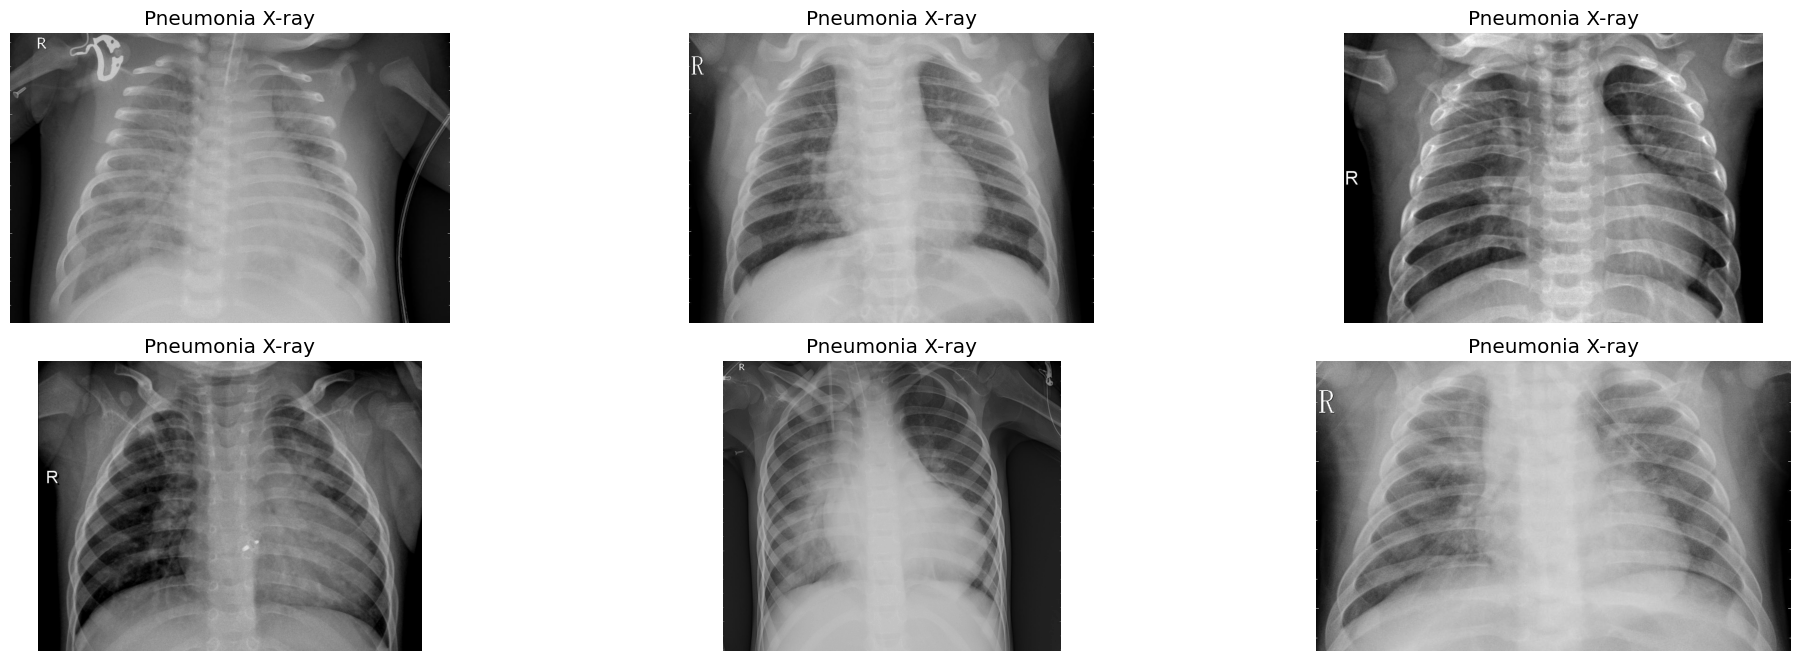

In [6]:
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()
plt.show()

In [7]:
normal = os.listdir("../DL/chest_xray/chest_xray/train/NORMAL")
normal_dir = "../DL/chest_xray/chest_xray/train/NORMAL"

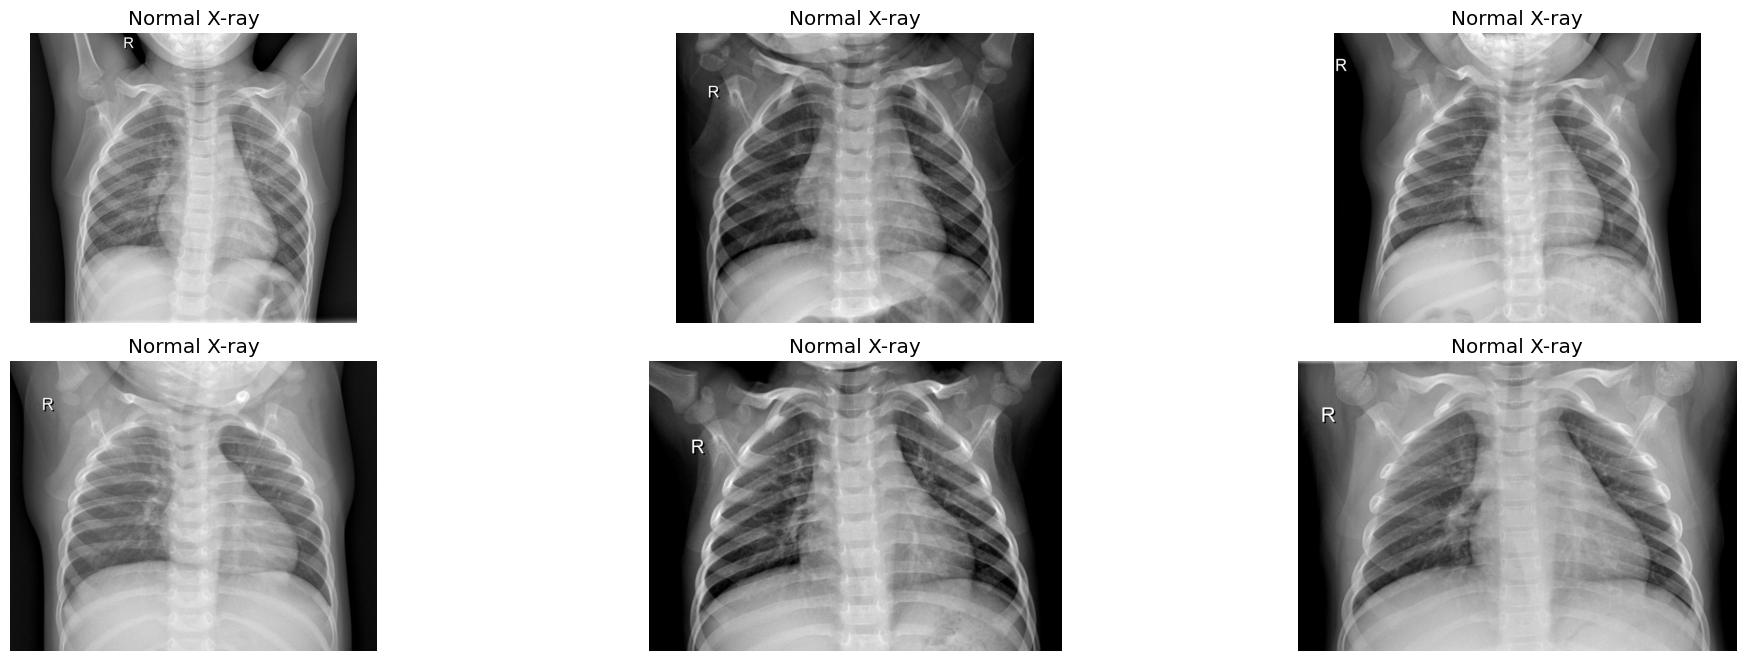

In [8]:
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()
plt.show()

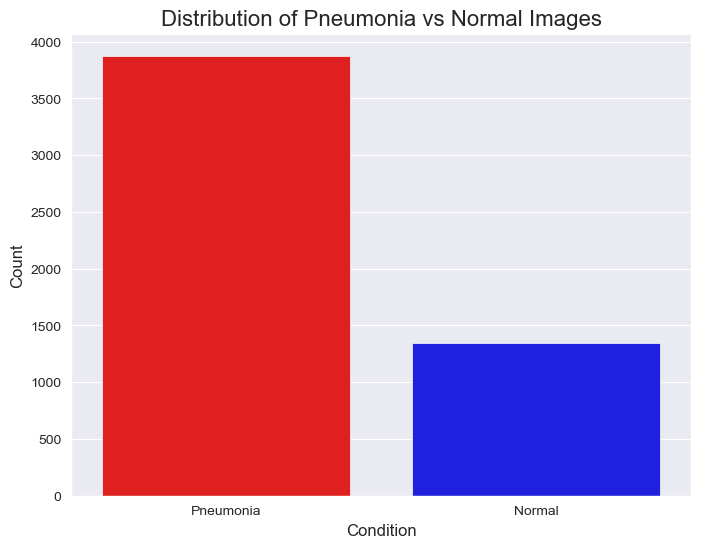

In [9]:

# Assuming `train_labels` contains the labels (0 for Pneumonia, 1 for Normal)
# Map 0 to 'Pneumonia' and 1 to 'Normal'
labels = ['Pneumonia' if label == 0 else 'Normal' for label in train_labels]

# Convert the list to a pandas Series to avoid the FutureWarning
labels_series = pd.Series(labels)

# Set Seaborn style
sns.set_style('darkgrid')

# Create the countplot with different colors for the bars, using hue
plt.figure(figsize=(8, 6))
sns.countplot(x=labels_series, hue=labels_series, palette={'Pneumonia': 'red', 'Normal': 'blue'}, legend=False)

# Add labels and title to the plot
plt.title('Distribution of Pneumonia vs Normal Images', fontsize=16)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()



In [10]:
# Data Augmentation & Resizing

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [12]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
class_labels = train_generator.class_indices

In [15]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
class_name = {value:key for (key, value) in class_labels.items()}

In [17]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [18]:
# DenseNet121 Architecture

In [19]:
class_labels = train_generator.class_indices
class_name = {value:key for (key, value) in class_labels.items()}

inputs = Input(shape=(128, 128, 3))
base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 87,851,458 (335.13 MB)

 Trainable params: 80,813,954 (308.28 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [20]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels, **kwargs):
        super().__init__(**kwargs)  # Fix for PyDataset warning
        self.data = data
        self.labels = labels



In [21]:
from keras.saving import save_model
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

history_01 = model_01.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10, 
    callbacks=[es, cp, lrr],
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

# Save the model after training
save_model(model_01, "model_01.keras")


C:\Users\patel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


C:\Users\patel\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 592ms/step - accuracy: 0.7910 - loss: 0.5620 - val_accuracy: 0.8125 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 553ms/step - accuracy: 0.9003 - loss: 0.2427 - val_accuracy: 0.9375 - val_loss: 0.2023 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.8974 - loss: 0.2569 - val_accuracy: 0.6875 - val_loss: 0.4807 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9104 - loss: 0.2184 - val_accuracy: 0.7500 - val_loss: 0.4212 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 532ms/step - accuracy: 0.9051 - loss: 0.2146 - val_accuracy: 0.8125 - val_loss: 0.2851 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - accuracy: 0.9121 - loss: 0.2097 - val_accuracy: 0.8750 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 6: early stopping


In [22]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [23]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 625 images belonging to 2 classes.


In [24]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8750 - loss: 0.2213
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 660ms/step - accuracy: 0.8566 - loss: 0.3906


In [25]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.22130697965621948
Validation Accuarcy: 0.875
Test Loss: 0.3645913600921631
Test Accuarcy: 0.8623999953269958


In [26]:
# Increamental unfreezing & fine tuning

In [27]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

NameError: name 'VGG19' is not defined

In [ ]:
base_model_layer_names

In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.5, nesterov = True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator, 
            steps_per_epoch=10,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

In [ ]:
# Unfreezing and fine tuning the entire network

In [ ]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.5, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [ ]:
history_03 = model_02.fit(train_generator, 
            steps_per_epoch=100,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)